In [1]:
# 导入库
import os
import math
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义TSPDataset类
class TSPDataset(Dataset):
    def __init__(self, num_nodes, num_samples, random_seed=42):
        super().__init__()
        
        self.num_nodes = num_nodes
        self.num_samples = num_samples
        self.random_seed = random_seed

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        seed = self.random_seed + idx
        generator = torch.Generator()
        generator.manual_seed(seed)
        sample = torch.rand(self.num_nodes, 2, generator=generator)
        return sample

In [3]:
# 定义reward函数
def reward(sols):
    # sols: (batch_size, seq_len, input_size)
    # lengths: (batch_size,)
    lengths = torch.norm(sols[:, 1:, :] - sols[:, :-1, :], dim=2).sum(dim=1)
    lengths += torch.norm(sols[:, -1, :] - sols[:, 0, :], dim=1)
    return lengths

In [4]:
# 定义Embedding类
class Embedding(nn.Module):
    def __init__(self, input_size, embedding_size):
        super().__init__()
        
        self.embedding = nn.Linear(input_size, embedding_size)
        
    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        # embedded: (batch_size, seq_len, embedding_size)
        embedded = self.embedding(inputs)
        return embedded

In [5]:
# 定义Attention类
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.W_ref = nn.Conv1d(hidden_size, hidden_size, 1, 1)
        self.W_q = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Parameter(torch.FloatTensor(hidden_size))
        std = 1. / math.sqrt(hidden_size)
        torch.nn.init.uniform_(self.V, -std, std)
        
    def forward(self, ref, query):
        # ref: (batch_size, seq_len, hidden_size)
        # query: (batch_size, hidden_size)
        batch_size, seq_len, _ = ref.size()
        # ref: (batch_size, hidden_size, seq_len)
        ref = ref.permute(0, 2, 1)
        # ref: (batch_size, hidden_size, seq_len)
        ref = self.W_ref(ref)
        # query: (batch_size, hidden_size, 1)
        query = self.W_q(query).unsqueeze(2)
        # expanded_query: (batch_size, hidden_size, seq_len)
        expanded_query = query.repeat(1, 1, seq_len)
        # V: (batch_size, 1, hidden_size)
        V = self.V.unsqueeze(0).unsqueeze(0).expand(batch_size, -1, -1)
        # logits: (batch_size, seq_len)
        logits = torch.bmm(V, torch.tanh(ref + expanded_query)).squeeze(1)
        
        return ref, logits

In [6]:
# 定义PointerNetwork类
class PtrNet(nn.Module):
    def __init__(self, embedding_size, hidden_size, seq_len, n_glimpses, use_temperature, T0):
        super().__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.n_glimpses = n_glimpses
        self.use_temperature = use_temperature
        self.temperature = T0
        
        self.embedding = Embedding(2, embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size)
        self.glimpse = Attention(hidden_size)
        
        self.decoder_init_input = nn.Parameter(torch.FloatTensor(embedding_size))
        std = 1. / math.sqrt(embedding_size)
        nn.init.uniform_(self.decoder_init_input, -std, std)
        
    def apply_mask_to_logits(self, logits, mask, idxs):
        # logits, mask: (batch_size, seq_len)
        # idxs: (batch_size,)
        batch_size = logits.size(0)
        clone_mask = mask.clone().detach()
        
        if idxs is not None:
            clone_mask[torch.arange(batch_size), idxs] = 1
            logits = logits.masked_fill(clone_mask.bool(), float('-inf'))
        return logits, clone_mask
    
    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = inputs.size()
        assert seq_len == self.seq_len
        
        prev_probs, prev_idxs = [], []
        idxs = None
        # masks: (batch_size, seq_len)
        mask = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=inputs.device)
        
        # embedded: (batch_size, seq_len, embedding_size)
        embedded = self.embedding(inputs)
        
        # encoder_output: (batch_size, seq_len, hidden_size)
        # hidden, context: (num_layers, batch_size, hidden_size)
        encoder_output, (hidden, context) = self.encoder(embedded)
        
        # decoder_input: (batch_size, embedded_size)
        decoder_input = self.decoder_init_input.unsqueeze(0).expand(batch_size, -1)
        
        for _ in range(seq_len):
            # hidden, context: (num_layers, batch_size, embedding_size)
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            # query: (batch_size, embedding_size)
            query = hidden.squeeze(0)
            
            for _ in range(self.n_glimpses):
                # ref: (batch_size, hidden_size, seq_len)
                # logits: (batch_size, seq_len)
                ref, logits = self.glimpse(encoder_output, query)
                # logits, mask: (batch_size, seq_len)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                # query: (batch_size, hidden_size)
                query = torch.bmm(ref, F.softmax(logits, dim=1).unsqueeze(2)).squeeze(2)
            
            # logits = (batch_size, seq_len)
            _, logits = self.pointer(encoder_output, query)
            # logits, mask: (batch_size, seq_len)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            # probs: (batch_size, seq_len)
            if self.use_temperature and self.training:
                probs = F.softmax(logits / self.temperature, dim=1)
            else:
                probs = F.softmax(logits, dim=1)
            # idxs: (batch_size,)
            idxs = torch.multinomial(probs, 1).squeeze(1)
            
            for old_idxs in prev_idxs:
                if old_idxs.eq(idxs).any():
                    idxs = torch.multinomial(probs, 1).squeeze(1)
                    
            # decoder_input: (batch_size, embedding_size)
            decoder_input = embedded[torch.arange(batch_size), idxs, :]
            
            prev_probs.append(probs[torch.arange(batch_size), idxs])
            prev_idxs.append(idxs)
        
        # prev_probs, prev_idxs: [seq_len, (batch_size,)]
        return prev_probs, prev_idxs

In [7]:
# 定义Actor类
class Actor(nn.Module):
    def __init__(self, embedding_size, hidden_size, seq_len, n_glimpses, use_temperature, T0, reward):
        super().__init__()
        
        self.reward = reward
        self.ptr = PtrNet(embedding_size, hidden_size, seq_len, n_glimpses, use_temperature, T0)
        
    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        batch_size, seq_len, input_size = inputs.size()
        
        # probs, idxs: [seq_len, (batch_size,)]
        probs, idxs = self.ptr(inputs)
        # probs: (batch_size, seq_len)
        probs = torch.stack(probs, dim=1)
        # idxs: (batch_size, seq_len)
        idxs = torch.stack(idxs, dim=1)
        # actions: (batch_size, seq_len, input_size)
        actions = inputs[torch.arange(batch_size).unsqueeze(1), idxs]
        # reward_values: (batch_size,)
        reward_values = self.reward(actions)
        return reward_values, idxs, probs

In [8]:
# 定义Critic类
class Critic(nn.Module):
    def __init__(self, embedding_size, hidden_size, n_process_blocks):
        super().__init__()
        
        self.n_process_blocks = n_process_blocks
        
        self.embedding = Embedding(2, embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.process_block = Attention(hidden_size)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        # embedded: (batch_size, seq_len, embedding_size)
        embedded = self.embedding(inputs)
        
        # encoder_output: (batch_size, seq_len, hidden_size)
        # hidden, context: (num_layers, batch_size, hidden_size)
        encoder_output, (hidden, context) = self.encoder(embedded)
        # query: (batch_size, hidden_size)
        query = hidden.squeeze(0)
        
        for _ in range(self.n_process_blocks):
            # ref: (batch_size, hidden_size, seq_len)
            # logits: (batch_size, seq_len)
            ref, logits = self.process_block(encoder_output, query)
            # query: (batch_size, hidden_size)
            query = torch.bmm(ref, F.softmax(logits, dim=1).unsqueeze(2)).squeeze(2)
        
        # critic_value: (batch_size,)
        critic_value = self.decoder(query).squeeze(1)
        return critic_value

In [9]:
# 训练
def train(args, train_dataset, val_dataset):
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.embedding_size, args.hidden_size, args.seq_len, args.n_glimpses, args.use_temperature, args.T0, reward).to(args.device)
    critic = Critic(args.embedding_size, args.hidden_size, args.n_process_blocks).to(args.device)
    actor_optim = optim.Adam(actor.parameters(), lr=args.lr)
    critic_optim = optim.Adam(critic.parameters(), lr=args.lr)
    
    step = 0
    best_length = float('inf')
    train_lengths, val_lengths = [], []
    writer = SummaryWriter()
    model_path = os.path.join(args.output_dir, args.name)
    
    for epoch in range(args.n_epochs):
        for batch_id, train_batch in enumerate(train_loader):
            actor.train()
            critic.train()
            # inputs: (batch_size, seq_len, input_size)
            inputs = train_batch.to(args.device)
            # reward_values: (batch_size,)
            # idxs, probs: (batch_size, seq_len)
            reward_values, idxs, probs = actor(inputs)
            # log_probs: (batch_size,)
            log_probs = torch.log(probs.clamp(min=1e-10)).sum(dim=1)
            log_probs = torch.clamp(log_probs, min=-100)
            # critic_values: (batch_size,)
            critic_values = critic(inputs)
            # advantage: (batch_size,)
            advantage = reward_values - critic_values.detach()
            # reinforce: (batch_size,)
            reinforce = advantage * log_probs
            # actor_loss: (1)
            actor_loss = reinforce.mean()
            # critic_loss: (1)
            critic_loss = F.mse_loss(critic_values, reward_values.detach())
            
            actor_optim.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(actor.parameters(), args.max_grad_norm)
            actor_optim.step()
            
            critic_optim.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(critic.parameters(), args.max_grad_norm)
            critic_optim.step()
            
            writer.add_scalar('Actor_Loss/train', actor_loss.item(), step)
            writer.add_scalar('Critic_Loss/train', critic_loss.item(), step)
            writer.add_scalar('Length/train', reward_values.mean().item(), step)
            step += 1
            
            if batch_id % 100 == 0:
                print(f"Epoch [{epoch + 1}/{args.n_epochs}], Batch [{batch_id + 1}/{len(train_loader)}], "
                      f"Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}, "
                      f"Reward: {reward_values.mean().item():.4f}")
                actor.eval()
                critic.eval()
                with torch.no_grad():
                    total_rewards, total_nums = 0, 0
                    for val_batch in val_loader:
                        inputs = val_batch.to(args.device)
                        actor_rewards, _, _ = actor(inputs)
                        total_rewards += actor_rewards.sum().item()
                        total_nums += inputs.size(0)
                    avg_reward = total_rewards / total_nums
                    writer.add_scalar('Length/validation', avg_reward, step)
                    print(f"Validation average reward after epoch {epoch + 1}: {avg_reward:.4f}")
                    
                    if avg_reward < best_length:
                        best_length = avg_reward
                        torch.save(actor.state_dict(), model_path)
                    
                    writer.add_scalar('Best length/validation', best_length, step)
        
        actor.ptr.temperature = args.T0 * (1 - epoch / (args.n_epochs - 1))
            
    writer.close()

In [10]:
# 画TSP示例图
def plot_tsp_paths(args, inputs, idxs, rewards):
    # inputs: (batch_size, seq_len, 2)
    # idxs: (batch_size, seq_len)
    # rewards: (batch_size,)
    inputs = inputs.cpu().numpy()
    idxs = idxs.cpu().numpy()
    rewards = rewards.cpu().numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(args.name)
    
    for i in range(8):
        ax = axes[i // 4, i % 4]
        coords = inputs[i]
        path = idxs[i]
        
        for j in range(len(path)):
            x1, y1 = coords[path[j - 1]]
            x2, y2 = coords[path[j]]
            ax.plot([x1, x2], [y1, y2], 'bo-')
        
        ax.scatter(coords[:, 0], coords[:, 1], c='red')
        ax.scatter(coords[0, 0], coords[0, 1], c='yellow')
        ax.set_title(f'Length: {rewards[i]:.3f}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [11]:
# 测试
def test1(args, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.embedding_size, args.hidden_size, args.seq_len, args.n_glimpses, False, args.T0, reward).to(args.device)
    actor.load_state_dict(torch.load(os.path.join(args.output_dir, args.name)))
    
    actor.eval()
    total_rewards, total_nums = 0, 0
    
    with torch.no_grad():
        for i, test_batch in enumerate(test_loader):
            inputs = test_batch.to(args.device)
            actor_rewards, idxs, _ = actor(inputs)
            total_rewards += actor_rewards.sum().item()
            total_nums += inputs.size(0)
            
            if i == 0 and inputs.size(0) >= 8:
                plot_tsp_paths(args, inputs[:8], idxs[:8], actor_rewards[:8])
            
    avg_reward = total_rewards / total_nums
    print(f"Test average reward (greedy): {avg_reward:.4f}")

In [12]:
# 定义参数
args = argparse.Namespace()
args.n_epochs = 20
args.batch_size = 128
args.lr = 1e-3
args.embedding_size = 128
args.hidden_size = 128
args.seq_len = 20
args.n_glimpses = 1
args.use_temperature = True
args.T0 = 5 
args.T = 2.
args.num_samples = 12800
args.n_process_blocks = 3
args.max_grad_norm = 1.
args.output_dir = 'output'
args.name = 'DRL4TSP_A2C_TSP' + str(args.seq_len)
args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.makedirs(args.output_dir, exist_ok=True)

In [13]:
# 生成数据集
train_dataset = TSPDataset(args.seq_len, 1000000)
val_dataset = TSPDataset(args.seq_len, 1000)
test_dataset = TSPDataset(args.seq_len, 1000)

In [14]:
print('Training started...')
train(args, train_dataset, val_dataset)
print('Training completed!')

Training started...
Epoch [1/20], Batch [1/7813], Actor Loss: -441.3340, Critic Loss: 109.9810, Reward: 10.4567
Validation average reward after epoch 1: 10.3849
Epoch [1/20], Batch [101/7813], Actor Loss: -15.9170, Critic Loss: 1.5334, Reward: 10.4560
Validation average reward after epoch 1: 10.3992
Epoch [1/20], Batch [201/7813], Actor Loss: 13.1607, Critic Loss: 1.7266, Reward: 10.4329
Validation average reward after epoch 1: 10.3678
Epoch [1/20], Batch [301/7813], Actor Loss: -5.8749, Critic Loss: 1.3114, Reward: 8.0206
Validation average reward after epoch 1: 7.4932
Epoch [1/20], Batch [401/7813], Actor Loss: -1.4693, Critic Loss: 0.8233, Reward: 7.1704
Validation average reward after epoch 1: 6.6849
Epoch [1/20], Batch [501/7813], Actor Loss: -5.9504, Critic Loss: 0.6515, Reward: 6.0647
Validation average reward after epoch 1: 5.1705
Epoch [1/20], Batch [601/7813], Actor Loss: 3.2133, Critic Loss: 0.5199, Reward: 5.5644
Validation average reward after epoch 1: 4.8665
Epoch [1/20],

Test started...


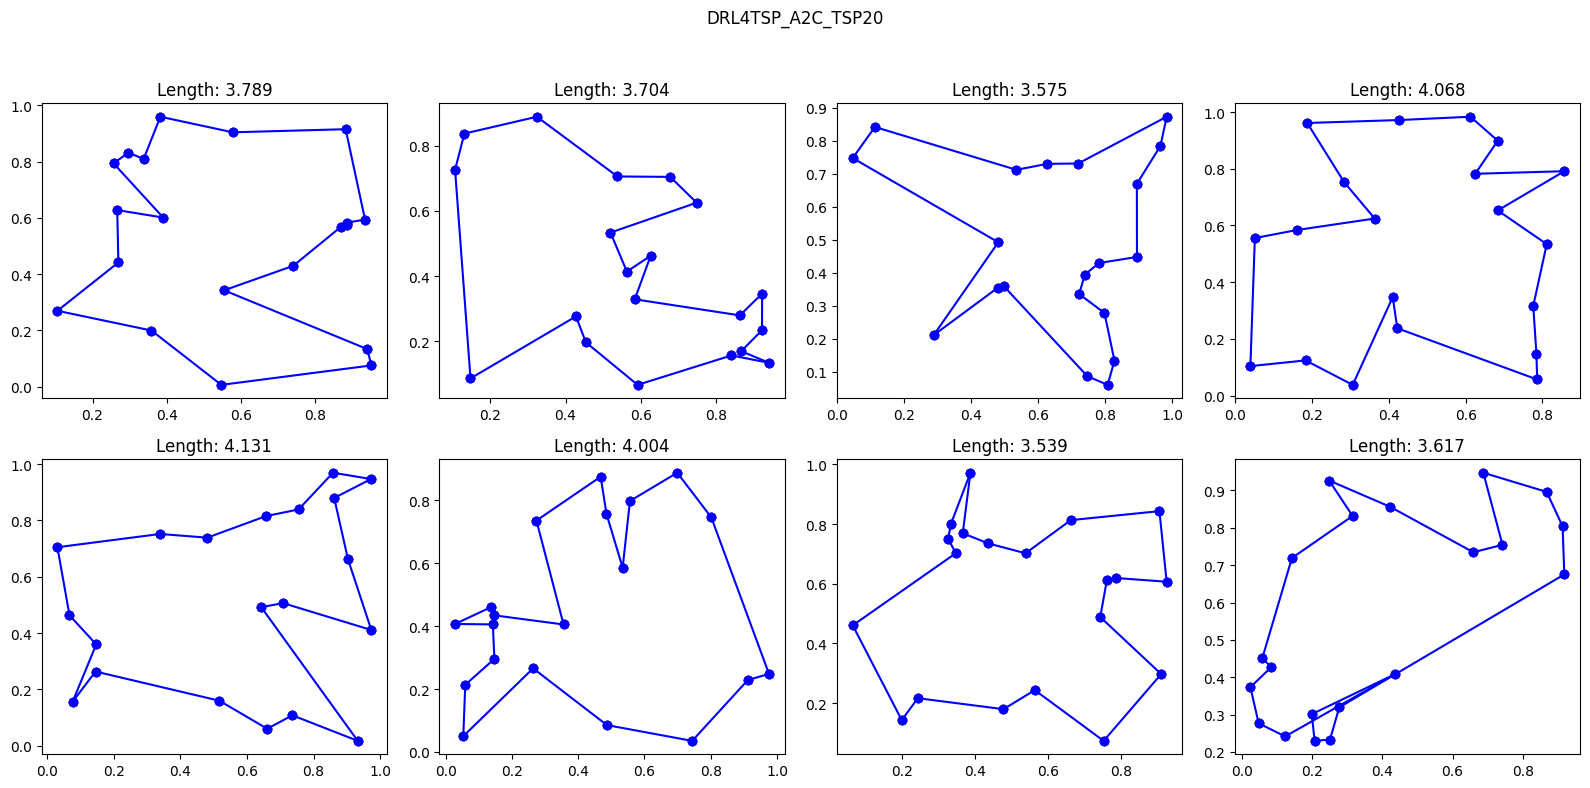

Test average reward (greedy): 3.9650
Test completed!


In [15]:
print('Test started...')
test1(args, test_dataset)
print('Test completed!')

In [16]:
# 测试 (sampling)
def sampling(actor, inputs, num_samples, sub_batch_size=1280):
    # inputs: (batch_size, seq_len, input_size)
    batch_size = inputs.size(0)
    best_idxs, best_rewards = [], []
    
    for i in range(batch_size):
        temp_input = inputs[i].unsqueeze(0)
        best_idx, best_reward = None, float('inf')
        
        num_sub_batches = (num_samples + sub_batch_size - 1) // sub_batch_size
        
        remaining_samples = num_samples
        for _ in range(num_sub_batches):
            current_batch_size = min(sub_batch_size, remaining_samples)
            remaining_samples -= current_batch_size
            
            temp_inputs = temp_input.repeat(current_batch_size, 1, 1)
            temp_rewards, temp_idxs, _ = actor(temp_inputs)
            
            sub_best_reward, sub_best_idx = temp_rewards.min(0)
            sub_best_reward = sub_best_reward.item()
            sub_best_idx = temp_idxs[sub_best_idx]
            
            if sub_best_reward < best_reward:
                best_idx = sub_best_idx
                best_reward = sub_best_reward
            
        best_idxs.append(best_idx)
        best_rewards.append(best_reward)
    
    return torch.tensor(best_rewards, device=inputs.device), torch.stack(best_idxs, dim=0).to(inputs.device)
        

def test2(args, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.embedding_size, args.hidden_size, args.seq_len, args.n_glimpses, True, args.T, reward).to(args.device)
    actor.load_state_dict(torch.load(os.path.join(args.output_dir, args.name)))
    
    actor.eval()
    total_rewards, total_nums = 0, 0
    
    with torch.no_grad():
        for i, test_batch in enumerate(test_loader):
            inputs = test_batch.to(args.device)
            actor_rewards, idxs = sampling(actor, inputs, args.num_samples)
            total_rewards += actor_rewards.sum().item()
            total_nums += inputs.size(0)
            
            if i == 0 and inputs.size(0) >= 8:
                plot_tsp_paths(args, inputs[:8], idxs[:8], actor_rewards[:8])
            
    avg_reward = total_rewards / total_nums
    print(f"Test average reward (sampling): {avg_reward:.4f}")

Test started...


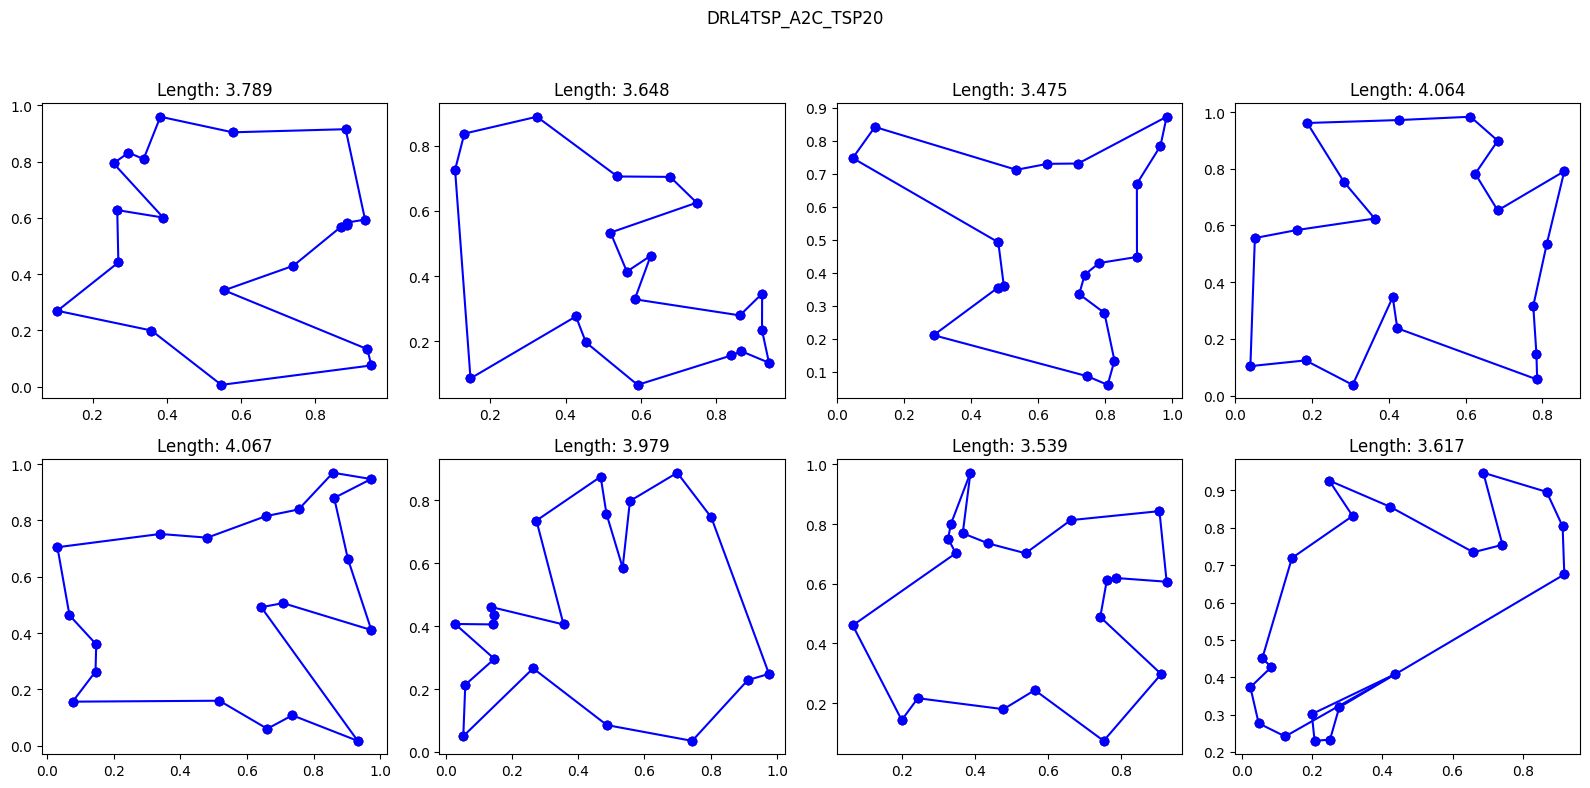

Test average reward (sampling): 3.9155
Test completed!


In [17]:
print('Test started...')
test2(args, test_dataset)
print('Test completed!')